In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

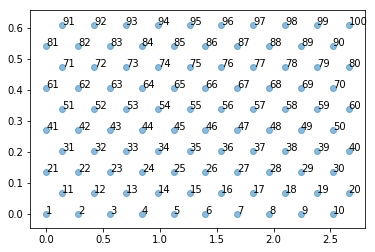

In [2]:
# N must be even and this will make a lattice with N points in x and N points in y directions

N = 10
d = 0.28

# set up square mesh

nx, ny = (N, N)
x = np.linspace(0, N-1, nx)*d
y = np.linspace(0, N-1, ny)*d
xv, yv = np.meshgrid(x, y)
xv_array = np.asarray(xv).reshape(-1)
yv_array = np.asarray(yv).reshape(-1)

# scaling for hexagonal points (in y)
y_scale = np.sqrt(3)/2*d
yv_hex = yv_array*y_scale

# shift for hexagonal points (in x) - for every second row, bump a bit to the right
no_shift = np.zeros((N))
yes_shift = np.ones((N))*d/2

# vector that contains shifts for x coordinate every second row in lattice
x_shift = np.concatenate((no_shift, yes_shift), axis=0)

xv_hex = xv_array + np.tile(x_shift, N//2)

coordinates_hex = np.vstack((xv_hex, yv_hex))

plt.scatter(coordinates_hex[0,:],coordinates_hex[1,:], alpha = 0.5)

for i in range(N**2):
    plt.text(coordinates_hex[0,i],coordinates_hex[1,i], str(i+1))

plt.show()

In [3]:
def neighbour(a):
    '''return neigbouring sites of a lattice position'''   
    x_even = np.linspace(0.5, N-0.5, nx)*d
    x_even = np.around(x_even, 2)
    x_odd = np.around(x, 2)
    sites = np.array([])
    
    def corners(a):
        '''checks if position is located at one of the corners'''
        c_sites = np.array([])
        if coordinates_hex[0,a] == 0.0 and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a+N-1, a+2*N-1, a+N, a+1, N**2-(N-a), N**2-1])
        if coordinates_hex[0,a] == d*(N-1) and coordinates_hex[1,a] == 0.0:
            c_sites = np.append(c_sites, [a-1, a+N-1, a+N, a-N+1, N**2-1,  (N**2-1)-(N-a)])
        if coordinates_hex[0,a] == d/2 and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a+N-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1,  a-N])
        if coordinates_hex[0,a] == d/2 + (N-1)*d and coordinates_hex[1,a] == y_scale*d*(N-1):
            c_sites = np.append(c_sites, [a-1, N-(N**2-a), 1, a-N+1, a-2*N+1, a-N])
        return c_sites
    
    def flcol(a):
        '''checks if position is located at the vertical sides'''
        value = round(xv_hex[a], 2)
        s_sites = np.array([])
        if a%N == 0:
            if value in x_odd: 
                s_sites = np.append(s_sites, [a+N-1, a+2*N-1, a+N, a+1, a-N, a-1])
            elif value in x_even:   
                s_sites = np.append(s_sites, [a+N-1, a+N, a+N+1, a+1, a-N+1, a-N])
        if (a+1)%N == 0:
            if value in x_odd:
                s_sites = np.append(s_sites, [a-1, a+N-1, a+N, a-N+1, a-N, a-N-1])
            elif value in x_even:
                s_sites = np.append(s_sites, [a-1, a+N, a+1, a-N+1, a-2*N+1, a-N])
        return s_sites
     
    def flrow(a):
        '''checks if position is located at the horizontal sides'''
        r_sites = np.array([])
        if a in np.arange(0,N):
            r_sites = np.append(r_sites, [a-1, a+N-1, a+N, a+1, N**2-(N-a), N**2-(N-a)-1])
        if a in np.arange(N**2-N, N**2):
            r_sites = np.append(r_sites, [a-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1, a-N])
        return r_sites
    
    def mid(a):
        '''checks if position is on "odd" row or "even" row'''
        value = round(xv_hex[a], 2)
        m_sites = np.array([])
        if value in x_odd:
            m_sites = np.append(m_sites, [a-1, a+N-1, a+N, a+1, a-N, a-N-1])
        if value in x_even:
            m_sites = np.append(m_sites, [a-1, a+N, a+N+1, a+1, a-N+1, a-N])
        return m_sites
    
    if len(corners(a))!= 0:
        sites = np.append(sites, corners(a))
        return sites
    elif len(flcol(a))!= 0:
        sites = np.append(sites, flcol(a))
        return sites
    elif len(flrow(a))!= 0:
        sites = np.append(sites, flrow(a))
        return sites
    else:
        sites = np.append(sites, mid(a))
        return sites

In [4]:
'''noise at lattice points'''
E = np.random.uniform(-0.1, 0.1, (N**2))

In [5]:
class Simulation:
    
    def __init__(self, E_act, time, noise, temp, no_runs, start_pos):
        # activation energy
        self.active = E_act
        # total diffusion time
        self.total = time
        # noise in system
        self.disorder = noise
        # number of points generated
        self.runs = no_runs
        # length of interval between points
        self.interval = time/no_runs
        # initiation point
        self.start = start_pos
        
        # angle between points and effect on external field
        angle = 60/180*np.pi
        self.field = np.array([1, np.cos(angle), -np.cos(angle), -1, -np.cos(angle), np.cos(angle)])
        self.xdist = np.array([-d, -d/2, d/2, d, d/2, -d/2])
        self.ydist = np.array([0, np.sqrt(3)/2*d, np.sqrt(3)/2*d, 0, -np.sqrt(3)/2*d, -np.sqrt(3)/2*d])
        kB = 8.617332e-5
        self.kT = kB * temp
        
        #track position
        self.hops = []

    
    def factor(self):
        '''returns pre-exponential factor for hopping rate '''
        return 2 * self.kT / 4.1357e-15
    
    def kmc(self):
        '''returns mean squared total displacement at set time intervals '''
        # choosing a random lattice point in the centre of lattice
        #a = np.random.randint(2*N,N**2-2*N)
        a = self.start
        # construct table
        df = pd.DataFrame([])
        
        tot_xdist = 0
        tot_ydist = 0
        
        time = 0 
        time_check = self.interval
        
        # keep tracks of time
        x_time = np.array([])
        # record mean squared displacement
        y_msd = np.array([])
        
        # simulation runs until sim_time is reached
        while time <= self.total:
            if self.disorder != 0:
                dE = np.array([])
                # retrieve neigbouring points from neigbour function
                for i in neighbour(a):
                    i = i.astype(int)
                    # adds noise to activation energy
                    dE = np.append(dE, E[i]*self.disorder + self.active)
            else:
                # condition when no noise is introduced to the system
                dE = np.ones(5)*self.active
                
            # can include electric field if needed 
            E_tot = dE
            # rate of hopping
            v = self.factor()*np.exp(-E_tot/self.kT)
            # generate random number
            Randnum1 = random.uniform(0,1) 
            # set position of pointer
            rk = Randnum1 * np.sum(v)
            # cumulative sum of energy
            k = np.cumsum(v)
            
            # going through k1, k1+k2...., ktotal
            for i in np.nditer(k):
            # if value smaller than pointer choose path
                if i > rk:
                    next_step = list(k).index(i)
                    break
            # generate second random number
            Randnum2 = random.uniform(0,1)
            # increment time for each step
            time = time +(-1/np.sum(v)) * np.log(Randnum2)
            # update a for new lattice site
            a = (neighbour(a)[next_step]).astype(int)
            # calculate total displacement in the x and y direction
            tot_xdist += self.xdist[next_step]
            tot_ydist += self.ydist[next_step]
            # calculate total displacement
            tot_dis = np.sqrt(np.square(tot_xdist)+np.square(tot_xdist))
            
            # for every time increment, output time and mean square displacement
            if time > time_check:
                x_time = np.append(x_time, time)
                y_msd = np.append(y_msd,np.square(tot_dis))
                time_check += self.interval
            data = pd.DataFrame({'time,s': x_time, 'MSD,nm^2': y_msd})
        return data
        

In [6]:
class Calc:
    
    def __init__(self, x, y):
        '''x and y are time and MSD from simulation'''
        self.data = x
        self.target = y
        # degrees of freedom
        self.df = len(y)-2
        self.z = np.polyfit(x, y, 1)
        self.p = np.poly1d(self.z)
    
    def plot(self):
        '''returns array to construct plot for linear fitting'''
        return self.p(self.data)
    
    def diff_coeff(self):
        slope, intercept = self.z
        return slope/ 4
        
    def ssx(self):
        '''returns sum of squared difference of x'''
        mean_x = np.mean(self.data)
        squared_diff = np.square(self.data-mean_x)
        return np.sum(squared_diff)
    
    def sse(self):
        '''error sum of squares'''
        squared_diff = np.square(self.target-self.plot())
        return np.sum(squared_diff)
    
    def std(self):
        '''standard deviation of gradient'''
        # variance of y(x)
        v_y = self.sse()/self.df
        # variance of gradient
        v_g = v_y/ self.ssx()
        return np.sqrt(v_g)

In [14]:
'''repeating for same number of runs '''
record = pd.DataFrame([])
for k in range(1000):
    '''E_act = 0.6eV, time = 0.1s, noise = 1, Temp = 278K, points = 100, starting point = 32'''
    run = Simulation(0.6, 0.1, 1, 278, 100, 31)
    data = run.kmc()
    record = pd.concat([record, data], axis=1, sort=False)
MSD = record.iloc[:, 1::2]
time = record.iloc[:, 0::2]
MSD_mean = MSD.mean(axis=1)
time_mean = time.mean(axis=1)
MSD_std = MSD.std(axis=1)
std_err = MSD_std/np.sqrt(1000)

print('done')

done


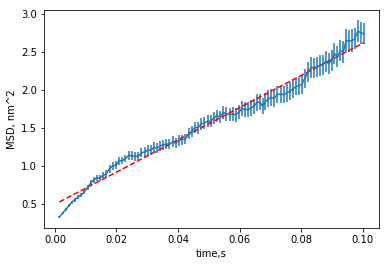

In [17]:
plt.errorbar(time_mean, MSD_mean, yerr=std_err)
z = np.polyfit(time_mean, MSD_mean, 1)
p = np.poly1d(z)
plt.plot(time_mean, p(time_mean),"r--")
plt.xlabel('time,s')
plt.ylabel('MSD, nm^2')
plt.savefig('MSD vs time')
plt.show()
plt.close()

In [20]:
result = Calc(time_mean, MSD_mean)
print(result.diff_coeff()*(10**-7)**2)
print(result.std())

5.290772930873564e-14
0.2856104108340227


In [7]:
'''initiating from different points'''
start_pos = np.array([31, 41, 51]).astype(int)
diff = np.array([])
for p in np.nditer(start_pos):
    record = pd.DataFrame([])
    for w in range(1000):
        run = Simulation(0.6, 0.1, 1, 278, 100, p)
        data = run.kmc()
        record = pd.concat([record, data], axis=1, sort=False)
    MSD = record.iloc[:, 1::2]
    time = record.iloc[:, 0::2]
    MSD_mean = MSD.mean(axis=1)
    time_mean = time.mean(axis=1)
    MSD_std = MSD.std(axis=1)
    r = Calc(time_mean, MSD_mean)
    diff = np.append(diff, r.diff_coeff()*(10**-7)**2)
    

In [8]:
print(diff)

[1.83137011e-13 2.12639305e-13 1.94157065e-13]


In [9]:
diff.std()

1.217200865496263e-14